In [1]:
from math import sqrt
import torch
import matplotlib.pyplot as plt
import Steerable.nn as snn

# Dataset

In [2]:
class GaussianDataset(torch.utils.data.Dataset):
    def __init__(self, size, mean=0.0, std=1.0, length=1000):
        self.mean = mean
        self.std = std
        self.size = size
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if idx >= self.length:
            raise ValueError(f'Index{idx} out of range for dataset of length {self.length}')
        image = torch.randn(self.size) * self.std + self.mean
        label = 0
        return image, label

# Function to Check Equivariance

In [3]:
device = torch.device('cuda')
def check_equivariance(model, dataset, transfomation=None):
    def diff_output(inputs1, inputs2):
        with torch.no_grad():
            outputs1 = model(inputs1.to(device))
            outputs2 = model(inputs2.to(device))

            return torch.max(torch.abs(outputs1 - outputs2)).item()
        
    n_sim = 50
    degrees = torch.arange(0, 361, 10)
    values = torch.zeros(n_sim, len(degrees))
    
    for sim in range(n_sim):
        inputs = dataset[torch.randint(0, len(dataset), (1,)).item()][0].unsqueeze(0)
        for i, degree in enumerate(degrees):
            inputs_rot = transfomation(inputs, degree) if transfomation else inputs
            values[sim, i] = diff_output(inputs, inputs_rot)

        print(f'{sim+1} / {n_sim}', end='\r')

    diff_mean = values.mean(dim=0)
    diff_std = values.std(dim=0)

    plt.plot(degrees, diff_mean)
    plt.fill_between(degrees, diff_mean-1.95*diff_std/sqrt(n_sim),  diff_mean+1.95*diff_std/sqrt(n_sim), color='blue', alpha=0.2)
    plt.xticks([45*i for i in range(degrees.max().item()//45 + 1)])
    for intercept in [90*i+45 for i in range(round(degrees.max().item()/90))]:
        plt.axvline(intercept, linestyle='dashed', color='red')
    plt.show()

# Two Dimension

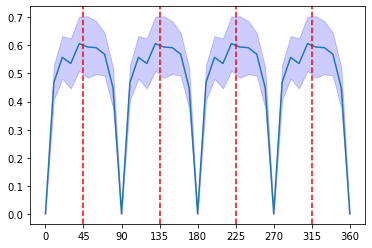

In [4]:
# Model
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        n_radius = 2
        max_m = 8
        n_theta = 40
        restricted = True
        conv_first = True
        
        self.network = torch.nn.Sequential(
            snn.SE2ConvType1(1, 2, 3, n_radius=n_radius, n_theta=n_theta, max_m=max_m, padding='same', conv_first = conv_first),
            snn.SE2NonLinearity(8),
            snn.SE2ConvType2(2, 2, 3, n_radius=n_radius, n_theta=n_theta, max_m=max_m, padding='same', restricted=restricted, conv_first = conv_first),
            snn.SE2BatchNorm(),
            
            snn.SE2AvgPool(4),
            snn.SE2ConvType2(2, 2, 7, n_radius=n_radius, n_theta=n_theta, max_m=max_m, restricted=restricted, conv_first = conv_first),
            
            snn.SE2NormFlatten()
        )

    def forward(self,x):
        return self.network(x.type(torch.cfloat))

# Check Equivariance
model = Model().to(device)
dataset = GaussianDataset(size =(1,28,28))
check_equivariance(model, dataset, lambda x,degree:snn.rotate_2D_image(x, degree))

# Three Dimension

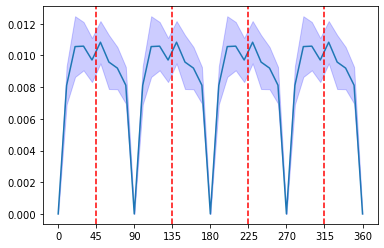

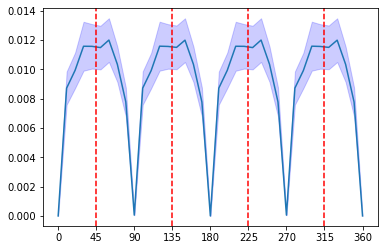

In [5]:
# Model
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        n_radius = 2
        n_theta = 40
        restricted = True
        conv_first = True
        
        self.network = torch.nn.Sequential(
            snn.SE3Conv(1, [2,3], 3, n_radius=n_radius, n_theta=n_theta, padding='same', restricted=restricted, conv_first=conv_first),
            snn.SE3NormNonLinearity([2,3]),
            snn.SE3Conv([2,3], [4,5], 3, n_radius=n_radius, n_theta=n_theta, padding='same', restricted=restricted, conv_first=conv_first),
            snn.SE3BatchNorm(),
            
            snn.SE3AvgPool(4),
            snn.SE3Conv([4, 5], [4, 5], 3, n_radius=n_radius, n_theta=n_theta, restricted=restricted, conv_first=conv_first),
            
            snn.SE3NormFlatten()
        )
    
    def forward(self,x):
        return self.network(x.type(torch.cfloat))
    
# Check Equivariance
model = Model().to(device)
dataset = GaussianDataset(size =(1,32,32,32))
check_equivariance(model, dataset, lambda x,degree:snn.rotate_3D_image(x, (degree,0,0)))
check_equivariance(model, dataset, lambda x,degree:snn.rotate_3D_image(x, (0,degree,0)))